I want to use PCA to reduce dimensionality on the fruit images. First I will fit with 50 components and look at the components as images. Then I will reconstruct the originals to see what gets lost. After that I will compare a simple classifier on raw pixels and on PCA features. Finally I will let PCA pick the number of components by explained variance and try clustering in the low dimensional space.

# Dimension and Dimensionality Reduction in Machine Learning

  ## What is a "Dimension"?
  - In machine learning, a **dimension** is simply a **feature** or **variable** that describes each data point.  
    Example: an image with 100×100 pixels has **10,000 dimensions** because each pixel is a feature.
  - High-dimensional data often contains redundancy, noise, and correlated features.
  - As the number of dimensions grows, algorithms can become slower and less effective (the **curse of dimensionality**).

  ## What is Dimensionality Reduction?
  - **Dimensionality reduction** means transforming data into a smaller set of important features while keeping as much useful information as possible.
  - It helps by  
    - reducing noise  
    - improving model performance  
    - speeding up training  
    - helping visualization (2D or 3D plots)

  ## Two Main Types of Dimensionality Reduction
  - **Feature Extraction**  
    Creates new features by combining or transforming the original ones.  
    Example: **PCA (Principal Component Analysis)** finds new axes that capture the most variance.

  - **Feature Selection**  
    Chooses a subset of the original features without altering them.  
    Example: selecting top-k most informative features.

  ## Why It Matters
  - Simplifies complex datasets  
  - Helps avoid overfitting  
  - Makes patterns clearer for both humans and algorithms

  Dimensionality reduction is essentially about finding a **smaller, smarter representation** of high-dimensional data.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans

# Load data and reshape

In [2]:
fruits = np.load('fruits_300_data')
fruits_2d = fruits.reshape(-1, 100*100)

fruits_2d[:5]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

# Fit PCA with 50 components

In [3]:
pca = PCA(n_components = 50)
pca.fit(fruits_2d) # doens't give the target param since it is a unsupervised learning

print(pca.components_.shape)

(50, 10000)


In [4]:
# Helper function to draw images in a grid
def draw_fruits(arr, ratio = 1):
    n = len(arr) # number of samples
    # draw 10 images per line. Calculate the total number of lines by dividing the samples by 10
    rows = int(np.ceil(n/10))
    # if there is 1 row, the number of columns is the number of samples. If not, there should be 10. 
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols,
                            figsize = (cols*ratio, rows*ratio), squeeze = False)
    for i in range(rows):
        for j in range(cols):
            if i * 10 + j < n: #draw until the quantity reaches 10
                axs[i, j].imshow(arr[i * 10 + j], cmap = 'gray_r')
            axs[i, j].axis('off')
    plt.show()

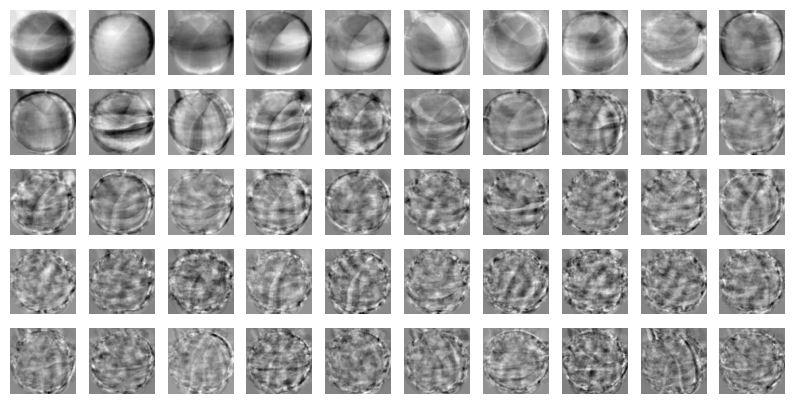

In [5]:
draw_fruits(pca.components_.reshape(-1, 100, 100))

This principal component shows the direction with the greatest variance in the original data in order. On the one hand, you can think of it as if you have captured a feature in the data set.

Since the main component was found, the number of projection term characteristics of the original data in the main component can be reduced from 10000 to 50. This can be thought of as decomposing the original data into each main component. We will reduce the dimension of the original data to 50 using PCA's transform() method.

# Project to PCA space and reconstruct

In [6]:
print(fruits_2d.shape,"\n")
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)


(300, 10000) 

(300, 50)


Although we reduced the number of characteristics to 50, this inevitably leads to some loss. However, since we projected the data in a direction with the greatest variance, we can reconstruct much of the original data

(300, 10000)


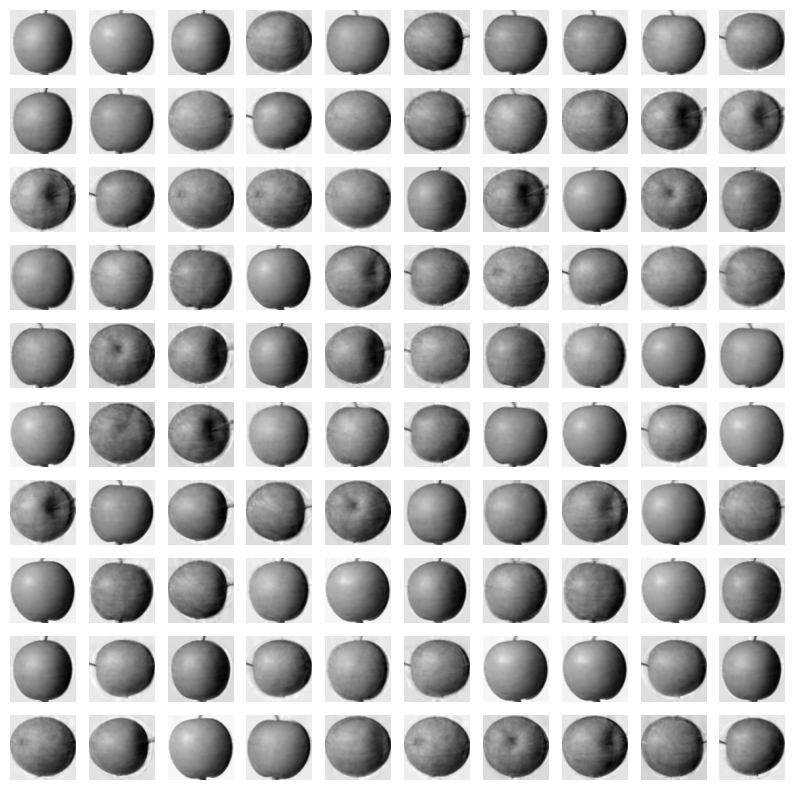

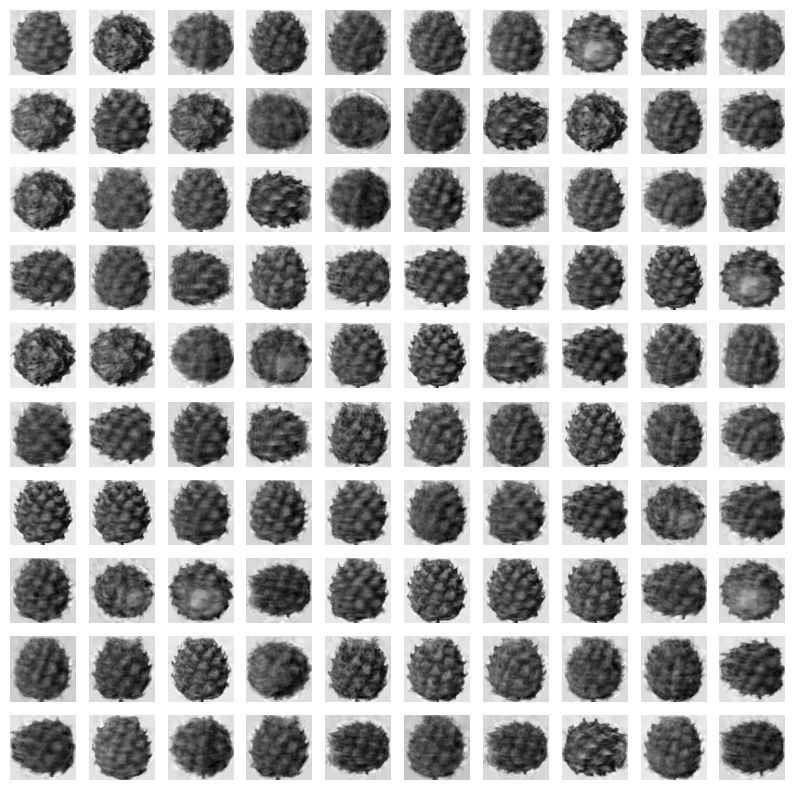

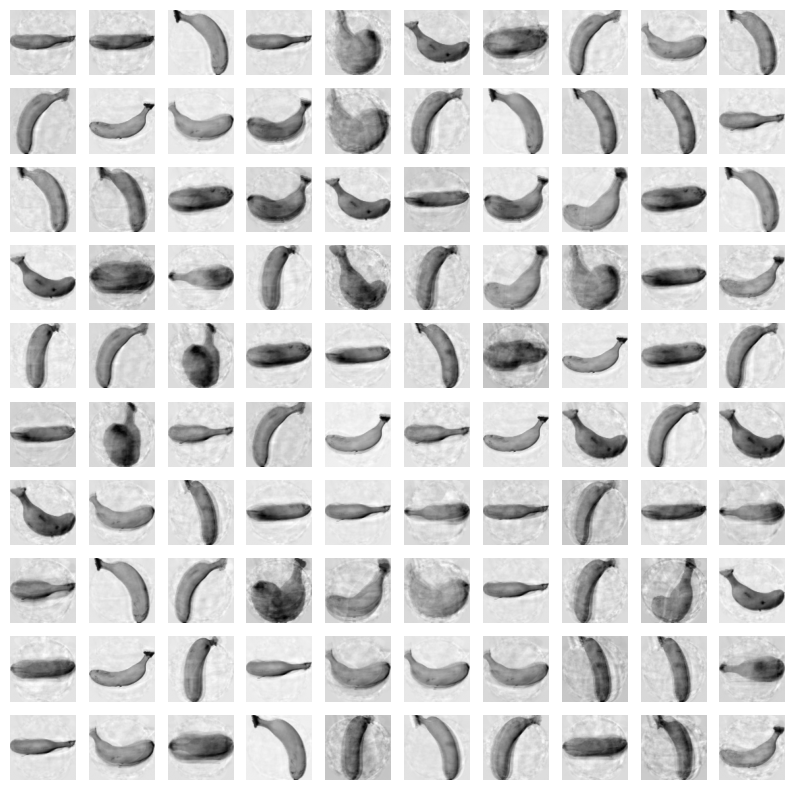

In [7]:
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)
for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")


# Explained variance

The values recorded how well the principal components represent the variance of the original data are called the explained variance.

In [8]:
print(np.sum(pca.explained_variance_ratio_))

0.9215193577167291


It maintains a variance of more than 92%. This is why the quality of the original image was high when the original data was restored from the previous 50 characteristics. Graphing the ratio of the variance described helps to find the appropriate number of principal components.

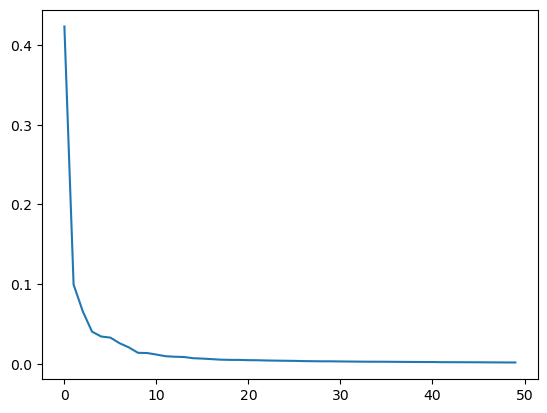

In [9]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

# the first 10 princinple components are explaining most of the variance, after that, it is relatively small.

# Pair PCA with a simple classifier

In [10]:
lr = LogisticRegression()

y = np.array([0]*100 + [1]*100 + [2]*100)

scores = cross_validate(lr, fruits_2d, y)

print(np.mean(scores['test_score']),'\n')
print(np.mean(scores['fit_time']))

0.9966666666666667 

0.16705784797668458


In [11]:
scores = cross_validate(lr, fruits_pca, y)

print(np.mean(scores['test_score']),'\n')
print(np.mean(scores['fit_time']))

0.9966666666666667 

0.008229446411132813


The accuracy should stay high while training time drops a lot which is the main benefit here

# Let PCA choose the dimension by variance

In [12]:
pca = PCA(n_components = 0.5)
pca.fit(fruits_2d)

print(pca.n_components_)

2


In [13]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [14]:
scores = cross_validate(lr, fruits_pca, y)

print(np.mean(scores['test_score']),'\n')
print(np.mean(scores['fit_time']))

0.9933333333333334 

0.013887643814086914


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Only by using 2 characteristics, we acheived 99% accuracy. 

Now lets use the K means algorithm to find the cluster with dimension reduced data.

In [15]:
km = KMeans(n_clusters = 3, random_state = 42)
km.fit(fruits_pca)

print(np.unique(km.labels_, return_counts = True))

(array([0, 1, 2], dtype=int32), array([110,  99,  91]))


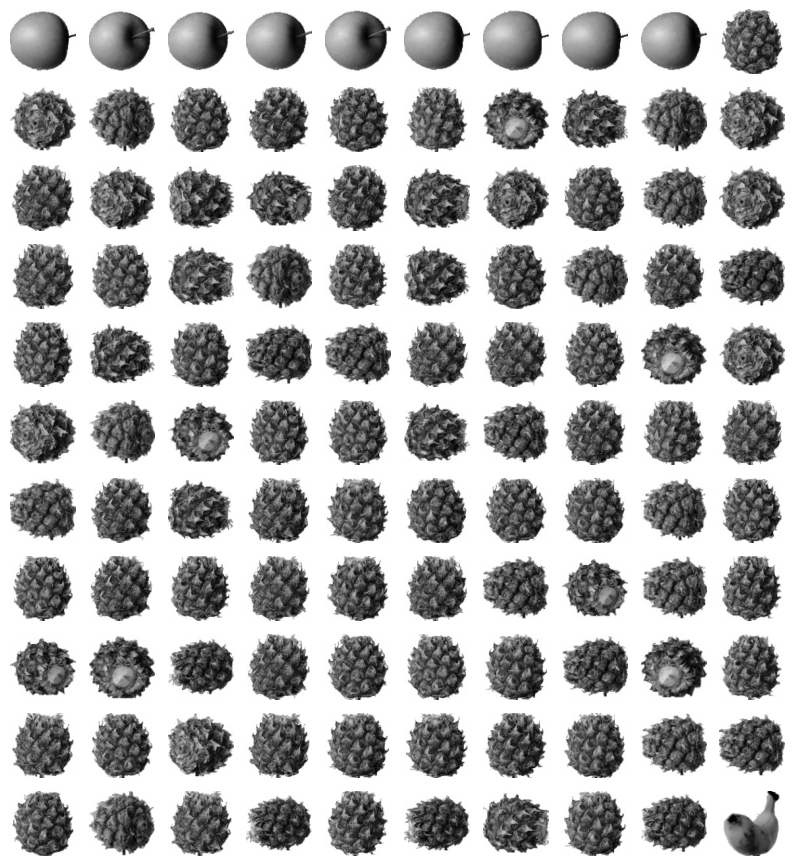

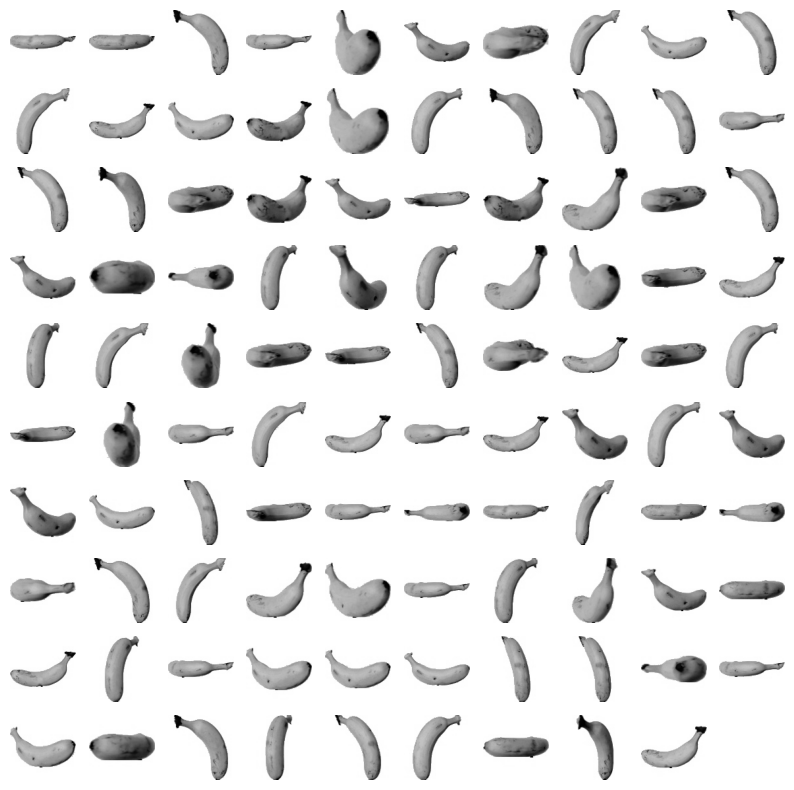

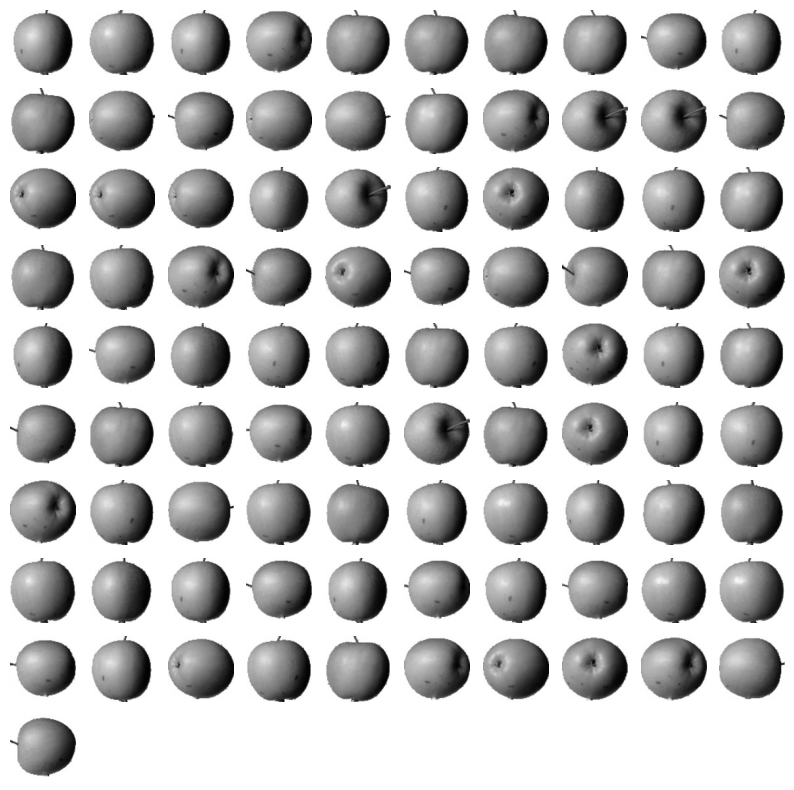

In [16]:
for label in range(0, 3):
    draw_fruits(fruits[km.labels_ == label])
    print("\n")

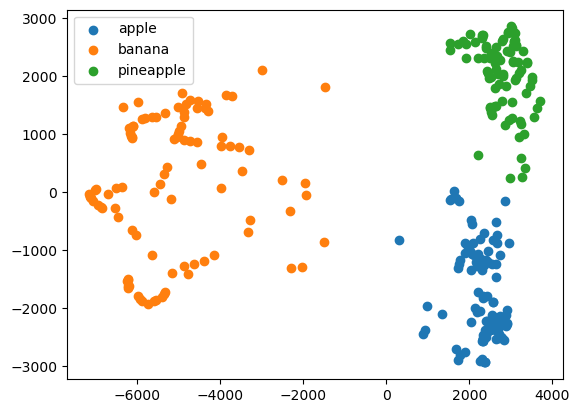

In [17]:
for label in range(0, 3):
    data = fruits_pca[km.labels_ == label]
    plt.scatter(data[:,0], data[:,1])

plt.legend(['apple', 'banana', 'pineapple'])
plt.show()

The scatterplot of each cluster is very well distinguished. We used only 2 properties, and here's why the logistic regression model has 99% cross-validation score

If you look at this figure, the boundary between the apple and pineapple clusters is close together. Several samples from these two clusters seem likely to be confusing. Visualizing the data can provide unexpected insights, and in that sense, dimensionality reduction is one of the most useful tools.

# What I learned

PCA gives me a compact set of directions that capture most of the variation in these images. With 50 components the reconstructions keep the main shapes while smoothing small details. A simple classifier on PCA features runs much faster with no real loss in accuracy. Letting PCA select components by variance is convenient and often lands in a very low dimensional space for this dataset. Clustering after PCA is easier to visualize and often cleaner since noise gets reduced during projection. If I need more control I can try standardizing per image or running PCA after centering each image by its mean intensity.